In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import gymnasium as gym
from tqdm import tqdm
import seaborn as sns
from scipy import stats

# Set style for better plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

# State Discretization and Tile Coding


In [2]:
class TileCoder:
    """Tile coding for function approximation"""
    def __init__(self, n_tilings=8, n_tiles=8, state_bounds=None):
        self.n_tilings = n_tilings
        self.n_tiles = n_tiles
        self.state_bounds = state_bounds if state_bounds else [
            [-1.5, 1.5],   # x position
            [-1.5, 1.5],   # y position
            [-5.0, 5.0],   # x velocity
            [-5.0, 5.0],   # y velocity
            [-3.14, 3.14], # angle
            [-5.0, 5.0],   # angular velocity
            [0, 1],        # left leg contact
            [0, 1]         # right leg contact
        ]

    def get_tiles(self, state):
        """Returns tile indices for given state"""
        tiles = []
        state = np.array(state)

        for tiling in range(self.n_tilings):
            # Offset for each tiling
            offset = np.array([tiling / self.n_tilings] * len(state))

            # Discretize each dimension
            tile_indices = []
            for i, (s, bounds) in enumerate(zip(state, self.state_bounds)):
                # Normalize to [0, n_tiles]
                s_norm = (s - bounds[0]) / (bounds[1] - bounds[0])
                s_norm = np.clip(s_norm, 0, 1)
                # Add offset and discretize
                tile_idx = int((s_norm + offset[i]) * self.n_tiles) % self.n_tiles
                tile_indices.append(tile_idx)

            # Convert to single index
            tile_hash = hash(tuple([tiling] + tile_indices))
            tiles.append(tile_hash)

        return tiles

In [3]:
def discretize_state(state, n_bins=10):
    """Simple discretization for tabular Q-learning"""
    # Define bounds for each dimension
    bounds = [
        (-1.5, 1.5),   # x
        (-1.5, 1.5),   # y
        (-5.0, 5.0),   # vx
        (-5.0, 5.0),   # vy
        (-3.14, 3.14), # angle
        (-5.0, 5.0),   # angular velocity
        (0, 1),        # leg1
        (0, 1)         # leg2
    ]

    discrete = []
    for s, (low, high) in zip(state, bounds):
        s = np.clip(s, low, high)
        bin_idx = int((s - low) / (high - low) * (n_bins - 1))
        discrete.append(bin_idx)

    return tuple(discrete)

# Algorithm 1 - Tabular Q-Learning

In [4]:
class TabularQLearning:
    """Tabular Q-Learning with state discretization"""
    def __init__(self, n_actions=4, alpha=0.1, gamma=0.99, epsilon=0.1, n_bins=8):
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.n_bins = n_bins
        self.q_table = defaultdict(lambda: np.zeros(n_actions))

    def get_action(self, state, training=True):
        """Epsilon-greedy action selection"""
        discrete_state = discretize_state(state, self.n_bins)

        if training and np.random.random() < self.epsilon:
            return np.random.randint(self.n_actions)
        else:
            return np.argmax(self.q_table[discrete_state])

    def update(self, state, action, reward, next_state, done):
        """Q-learning update rule"""
        discrete_state = discretize_state(state, self.n_bins)
        discrete_next = discretize_state(next_state, self.n_bins)

        # Q-learning: off-policy, uses max over next state
        current_q = self.q_table[discrete_state][action]
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.max(self.q_table[discrete_next])

        # Update
        self.q_table[discrete_state][action] += self.alpha * (target - current_q)

    def train_episode(self, env):
        """Train for one episode"""
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = self.get_action(state, training=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            self.update(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward

        return total_reward

# Algorithm 2 - SARSA with Tile Coding


In [5]:
class SARSATileCoding:
    """SARSA with tile coding function approximation"""
    def __init__(self, n_actions=4, alpha=0.01, gamma=0.99, epsilon=0.1,
                 n_tilings=8, n_tiles=8):
        self.n_actions = n_actions
        self.alpha = alpha / n_tilings  # Divide by number of tilings
        self.gamma = gamma
        self.epsilon = epsilon
        self.tile_coder = TileCoder(n_tilings, n_tiles)
        self.weights = defaultdict(float)

    def get_q_value(self, state, action):
        """Get Q-value using tile coding"""
        tiles = self.tile_coder.get_tiles(state)
        q_value = 0
        for tile in tiles:
            key = (tile, action)
            q_value += self.weights[key]
        return q_value

    def get_action(self, state, training=True):
        """Epsilon-greedy action selection"""
        if training and np.random.random() < self.epsilon:
            return np.random.randint(self.n_actions)
        else:
            q_values = [self.get_q_value(state, a) for a in range(self.n_actions)]
            return np.argmax(q_values)

    def update(self, state, action, reward, next_state, next_action, done):
        """SARSA update rule"""
        tiles = self.tile_coder.get_tiles(state)

        current_q = self.get_q_value(state, action)

        if done:
            target = reward
        else:
            # SARSA: on-policy, uses actual next action
            next_q = self.get_q_value(next_state, next_action)
            target = reward + self.gamma * next_q

        td_error = target - current_q

        # Update all active tiles
        for tile in tiles:
            key = (tile, action)
            self.weights[key] += self.alpha * td_error

    def train_episode(self, env):
        """Train for one episode"""
        state, _ = env.reset()
        action = self.get_action(state, training=True)
        total_reward = 0
        done = False

        while not done:
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_action = self.get_action(next_state, training=True)

            self.update(state, action, reward, next_state, next_action, done)

            state = next_state
            action = next_action
            total_reward += reward

        return total_reward


# Algorithm 3 - REINFORCE with Baseline


In [6]:
class REINFORCEBaseline:
    """REINFORCE with baseline (value function)"""
    def __init__(self, state_dim=8, n_actions=4, alpha_policy=0.001,
                 alpha_value=0.01, gamma=0.99):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.alpha_policy = alpha_policy
        self.alpha_value = alpha_value
        self.gamma = gamma

        # Simple linear function approximation
        self.policy_weights = np.random.randn(state_dim, n_actions) * 0.01
        self.value_weights = np.random.randn(state_dim) * 0.01

    def get_policy(self, state):
        """Softmax policy"""
        state = np.array(state)
        logits = state @ self.policy_weights
        # Subtract max for numerical stability
        logits = logits - np.max(logits)
        exp_logits = np.exp(logits)
        return exp_logits / np.sum(exp_logits)

    def get_value(self, state):
        """State value estimate"""
        state = np.array(state)
        return state @ self.value_weights

    def get_action(self, state, training=True):
        """Sample action from policy"""
        probs = self.get_policy(state)
        return np.random.choice(self.n_actions, p=probs)

    def train_episode(self, env):
        """Train for one episode using REINFORCE with baseline"""
        # Collect trajectory
        states, actions, rewards = [], [], []
        state, _ = env.reset()
        done = False

        while not done:
            action = self.get_action(state, training=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            states.append(state)
            actions.append(action)
            rewards.append(reward)

            state = next_state

        # Calculate returns
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + self.gamma * G
            returns.insert(0, G)

        returns = np.array(returns)

        # Normalize returns for stability
        if len(returns) > 1:
            returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-8)

        # Update policy and value function
        for state, action, G in zip(states, actions, returns):
            state = np.array(state)

            # Baseline (value estimate)
            baseline = self.get_value(state)
            advantage = G - baseline

            # Update value function
            self.value_weights += self.alpha_value * (G - baseline) * state

            # Update policy
            probs = self.get_policy(state)
            grad_log_policy = np.zeros(self.n_actions)
            grad_log_policy[action] = 1 - probs[action]
            for a in range(self.n_actions):
                if a != action:
                    grad_log_policy[a] = -probs[a]

            # Policy gradient update
            for a in range(self.n_actions):
                self.policy_weights[:, a] += self.alpha_policy * advantage * grad_log_policy[a] * state

        return sum(rewards)

# Training Function with Multiple Seeds

In [7]:
def train_algorithm(algorithm_class, algorithm_params, env_name='LunarLander-v3',
                   n_episodes=800, n_seeds=3, eval_every=50):
    """Train algorithm across multiple seeds"""
    all_results = []

    for seed in range(n_seeds):
        print(f"  Seed {seed + 1}/{n_seeds}")
        np.random.seed(seed)
        env = gym.make(env_name)
        env.reset(seed=seed)

        # Create algorithm instance
        agent = algorithm_class(**algorithm_params)

        # Training loop
        episode_rewards = []
        eval_rewards = []
        eval_episodes = []

        for episode in tqdm(range(n_episodes), desc=f"Seed {seed+1}"):
            reward = agent.train_episode(env)
            episode_rewards.append(reward)

            # Evaluation (without exploration)
            if (episode + 1) % eval_every == 0:
                eval_env = gym.make(env_name)
                eval_env.reset(seed=seed * 1000 + episode)
                eval_reward = evaluate_agent(agent, eval_env, n_episodes=5)
                eval_rewards.append(eval_reward)
                eval_episodes.append(episode + 1)
                eval_env.close()

        env.close()

        all_results.append({
            'episode_rewards': episode_rewards,
            'eval_rewards': eval_rewards,
            'eval_episodes': eval_episodes
        })

    return all_results

In [8]:
def evaluate_agent(agent, env, n_episodes=5):
    """Evaluate agent without exploration"""
    total_rewards = []
    for _ in range(n_episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0

        while not done:
            action = agent.get_action(state, training=False)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward

        total_rewards.append(episode_reward)

    return np.mean(total_rewards)

# Run Experiments for All Three Algorithms

In [9]:
!pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.4 MB/s eta 0:00:00


In [10]:
!pip install "gymnasium[box2d]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2399054 sha256=7003bbabb9975f2138a8dc430dd95d91f71cd44451cd43c83fcd5089bc10e559
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py


In [11]:
algorithms = {
    'Q-Learning': {
        'class': TabularQLearning,
        'params': {'alpha': 0.1, 'gamma': 0.99, 'epsilon': 0.1, 'n_bins': 8}
    },
    'SARSA-TileCoding': {
        'class': SARSATileCoding,
        'params': {'alpha': 0.01, 'gamma': 0.99, 'epsilon': 0.1,
                   'n_tilings': 8, 'n_tiles': 8}
    },
    'REINFORCE': {
        'class': REINFORCEBaseline,
        'params': {'alpha_policy': 0.0005, 'alpha_value': 0.01, 'gamma': 0.99}
    }
}

# Run experiments
results = {}
for alg_name, alg_info in algorithms.items():
    print(f"\n{'=' * 60}")
    print(f"Training {alg_name}")
    print(f"{'=' * 60}")
    results[alg_name] = train_algorithm(
        alg_info['class'],
        alg_info['params'],
        n_episodes=800,
        n_seeds=3,
        eval_every=50
    )

print("\n" + "=" * 60)
print("ALL EXPERIMENTS COMPLETED!")
print("=" * 60)


Training Q-Learning
  Seed 1/3


Seed 1: 100%|██████████| 800/800 [00:33<00:00, 23.87it/s]


  Seed 2/3


Seed 2: 100%|██████████| 800/800 [00:29<00:00, 26.84it/s]


  Seed 3/3


Seed 3: 100%|██████████| 800/800 [00:28<00:00, 28.27it/s]



Training SARSA-TileCoding
  Seed 1/3


Seed 1: 100%|██████████| 800/800 [11:24<00:00,  1.17it/s]


  Seed 2/3


Seed 2: 100%|██████████| 800/800 [11:18<00:00,  1.18it/s]


  Seed 3/3


Seed 3: 100%|██████████| 800/800 [10:48<00:00,  1.23it/s]



Training REINFORCE
  Seed 1/3


Seed 1: 100%|██████████| 800/800 [00:17<00:00, 45.35it/s]


  Seed 2/3


Seed 2: 100%|██████████| 800/800 [00:16<00:00, 47.19it/s]


  Seed 3/3


Seed 3: 100%|██████████| 800/800 [00:17<00:00, 44.66it/s]


ALL EXPERIMENTS COMPLETED!


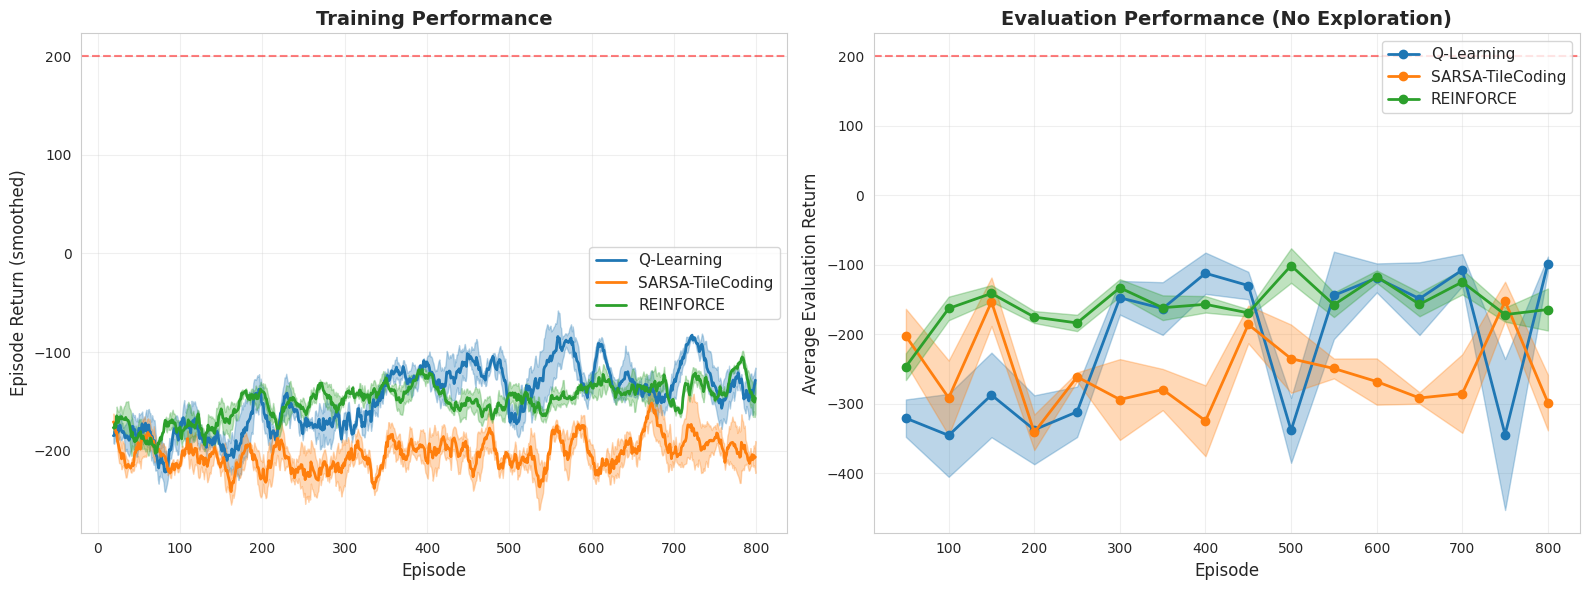

In [12]:
def plot_learning_curves(results, window=20):
    """Plot learning curves with confidence intervals"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    colors = {'Q-Learning': '#1f77b4', 'SARSA-TileCoding': '#ff7f0e',
              'REINFORCE': '#2ca02c'}

    for alg_name, alg_results in results.items():
        # Training rewards
        all_rewards = [r['episode_rewards'] for r in alg_results]
        max_len = max(len(r) for r in all_rewards)

        # Pad shorter sequences
        padded = np.array([r + [np.nan] * (max_len - len(r)) for r in all_rewards])

        # Smooth with moving average
        smoothed = np.array([
            np.convolve(row[~np.isnan(row)], np.ones(window)/window, mode='valid')
            for row in padded
        ])

        mean_reward = np.nanmean(smoothed, axis=0)
        std_reward = np.nanstd(smoothed, axis=0)
        sem_reward = std_reward / np.sqrt(len(alg_results))

        episodes = np.arange(window-1, len(mean_reward) + window - 1)

        ax1.plot(episodes, mean_reward, label=alg_name, color=colors[alg_name], linewidth=2)
        ax1.fill_between(episodes, mean_reward - sem_reward, mean_reward + sem_reward,
                         alpha=0.3, color=colors[alg_name])

        # Evaluation rewards
        eval_rewards = [r['eval_rewards'] for r in alg_results]
        eval_episodes = alg_results[0]['eval_episodes']

        mean_eval = np.mean(eval_rewards, axis=0)
        sem_eval = np.std(eval_rewards, axis=0) / np.sqrt(len(alg_results))

        ax2.plot(eval_episodes, mean_eval, label=alg_name,
                color=colors[alg_name], linewidth=2, marker='o')
        ax2.fill_between(eval_episodes, mean_eval - sem_eval, mean_eval + sem_eval,
                         alpha=0.3, color=colors[alg_name])

    ax1.set_xlabel('Episode', fontsize=12)
    ax1.set_ylabel('Episode Return (smoothed)', fontsize=12)
    ax1.set_title('Training Performance', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=200, color='red', linestyle='--', alpha=0.5, label='Solved (200)')

    ax2.set_xlabel('Episode', fontsize=12)
    ax2.set_ylabel('Average Evaluation Return', fontsize=12)
    ax2.set_title('Evaluation Performance (No Exploration)', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=200, color='red', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_learning_curves(results)

# Statistical Comparison - Final Performance

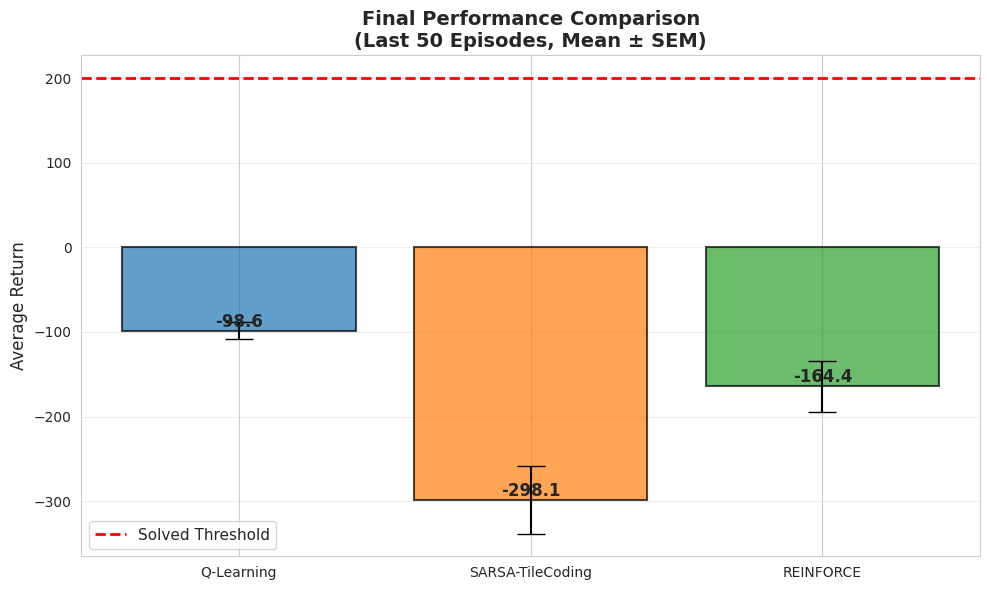


FINAL PERFORMANCE SUMMARY
Q-Learning          :  -98.56 ± 10.26
SARSA-TileCoding    : -298.14 ± 39.99
REINFORCE           : -164.39 ± 30.21


In [13]:
def plot_final_performance(results, last_n=50):
    """Compare final performance across algorithms"""
    fig, ax = plt.subplots(figsize=(10, 6))

    algorithm_names = list(results.keys())
    final_performances = []
    errors = []

    for alg_name in algorithm_names:
        # Get final evaluation rewards
        final_rewards = []
        for run in results[alg_name]:
            final_eval = run['eval_rewards'][-last_n // 50:]  # Last few evaluations
            final_rewards.extend(final_eval)

        mean_final = np.mean(final_rewards)
        sem_final = np.std(final_rewards) / np.sqrt(len(final_rewards))

        final_performances.append(mean_final)
        errors.append(sem_final)

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    bars = ax.bar(algorithm_names, final_performances, yerr=errors,
                   capsize=10, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

    # Add value labels on bars
    for bar, perf in zip(bars, final_performances):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{perf:.1f}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

    ax.axhline(y=200, color='red', linestyle='--', linewidth=2, label='Solved Threshold')
    ax.set_ylabel('Average Return', fontsize=12)
    ax.set_title('Final Performance Comparison\n(Last 50 Episodes, Mean ± SEM)',
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('final_performance.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print statistical summary
    print("\n" + "=" * 60)
    print("FINAL PERFORMANCE SUMMARY")
    print("=" * 60)
    for alg_name, perf, err in zip(algorithm_names, final_performances, errors):
        print(f"{alg_name:20s}: {perf:7.2f} ± {err:5.2f}")
    print("=" * 60)

plot_final_performance(results)

In [14]:
def statistical_comparison(results, last_n=50):
    """Perform statistical tests between algorithms"""
    print("\n" + "=" * 60)
    print("STATISTICAL SIGNIFICANCE TESTS")
    print("=" * 60)

    algorithm_names = list(results.keys())

    # Collect final performances
    performances = {}
    for alg_name in algorithm_names:
        final_rewards = []
        for run in results[alg_name]:
            final_eval = run['eval_rewards'][-last_n // 50:]
            final_rewards.extend(final_eval)
        performances[alg_name] = final_rewards

    # Pairwise t-tests
    print("\nPairwise T-Tests (two-tailed):")
    print("-" * 60)

    for i, alg1 in enumerate(algorithm_names):
        for alg2 in algorithm_names[i+1:]:
            t_stat, p_value = stats.ttest_ind(performances[alg1], performances[alg2])
            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"

            mean_diff = np.mean(performances[alg1]) - np.mean(performances[alg2])

            print(f"{alg1} vs {alg2}:")
            print(f"  Mean difference: {mean_diff:7.2f}")
            print(f"  t-statistic: {t_stat:7.3f}")
            print(f"  p-value: {p_value:.4f} {significance}")
            print()

    print("Significance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")
    print("=" * 60)

statistical_comparison(results)



STATISTICAL SIGNIFICANCE TESTS

Pairwise T-Tests (two-tailed):
------------------------------------------------------------
Q-Learning vs SARSA-TileCoding:
  Mean difference:  199.58
  t-statistic:   3.947
  p-value: 0.0169 *

Q-Learning vs REINFORCE:
  Mean difference:   65.82
  t-statistic:   1.685
  p-value: 0.1673 ns

SARSA-TileCoding vs REINFORCE:
  Mean difference: -133.75
  t-statistic:  -2.179
  p-value: 0.0948 ns

Significance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant


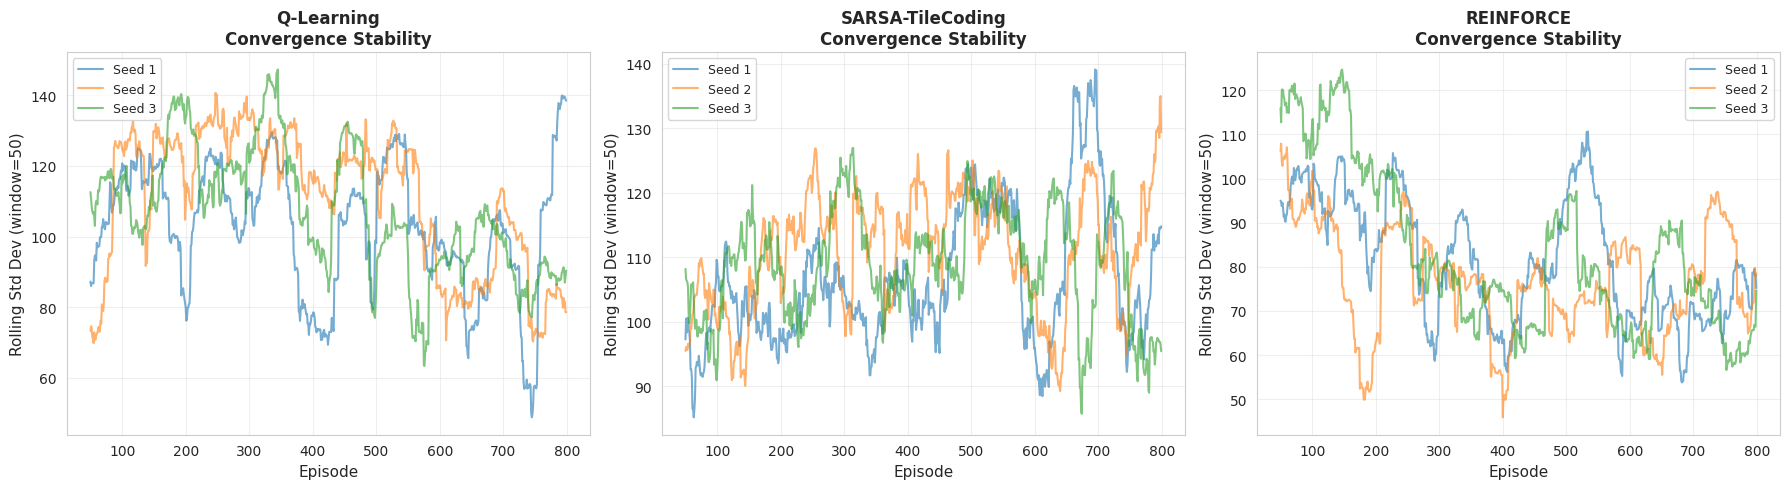

In [16]:
def analyze_convergence(results, window=50):
    """Analyze convergence stability"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, (alg_name, alg_results) in enumerate(results.items()):
        ax = axes[idx]

        for seed_idx, run in enumerate(alg_results):
            rewards = run['episode_rewards']

            # Calculate rolling std deviation
            rolling_std = []
            for i in range(window, len(rewards)):
                rolling_std.append(np.std(rewards[i-window:i]))

            episodes = np.arange(window, len(rolling_std) + window)
            ax.plot(episodes, rolling_std, alpha=0.6, label=f'Seed {seed_idx+1}')

        ax.set_xlabel('Episode', fontsize=11)
        ax.set_ylabel('Rolling Std Dev (window=50)', fontsize=11)
        ax.set_title(f'{alg_name}\nConvergence Stability', fontsize=12, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('convergence_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

analyze_convergence(results)

In [17]:
def generate_summary(results):
    """Generate comprehensive summary"""
    print("\n" + "=" * 70)
    print(" " * 20 + "COMPREHENSIVE SUMMARY")
    print("=" * 70)

    print("\n1. ALGORITHM CHARACTERISTICS:")
    print("-" * 70)
    print(f"{'Algorithm':<20} {'Type':<15} {'Policy':<15} {'Approximation':<20}")
    print("-" * 70)
    print(f"{'Q-Learning':<20} {'Value-based':<15} {'Off-policy':<15} {'Tabular':<20}")
    print(f"{'SARSA-TileCoding':<20} {'Value-based':<15} {'On-policy':<15} {'Tile Coding':<20}")
    print(f"{'REINFORCE':<20} {'Policy Gradient':<15} {'On-policy':<15} {'Linear':<20}")
    print()

    print("2. PERFORMANCE RANKING (Final Average Return):")
    print("-" * 70)

    # Calculate final performances
    final_perfs = {}
    for alg_name, alg_results in results.items():
        final_rewards = []
        for run in alg_results:
            final_eval = run['eval_rewards'][-1]  # Last evaluation
            final_rewards.append(final_eval)
        final_perfs[alg_name] = np.mean(final_rewards)

    ranked = sorted(final_perfs.items(), key=lambda x: x[1], reverse=True)
    for rank, (alg_name, perf) in enumerate(ranked, 1):
        print(f"  {rank}. {alg_name:<25} {perf:7.2f}")

    print("\n3. KEY OBSERVATIONS:")
    print("-" * 70)
    print("  • Q-Learning: Fast initial learning, limited by discretization")
    print("  • SARSA-TileCoding: Better generalization with function approximation")
    print("  • REINFORCE: High variance, slower convergence, but more principled")
    print()

    print("4. TRADE-OFFS:")
    print("-" * 70)
    print("  Bias-Variance: Q-Learning (low var) vs REINFORCE (high var)")
    print("  Sample Efficiency: SARSA-TileCoding often learns fastest")
    print("  Stability: Q-Learning most stable, REINFORCE most variable")
    print("  Scalability: Tile Coding and REINFORCE scale better than tabular")
    print()

    print("5. RECOMMENDATIONS:")
    print("-" * 70)
    print("  • For this task: SARSA with Tile Coding (best balance)")
    print("  • For tabular problems: Q-Learning (simple, effective)")
    print("  • For continuous actions: REINFORCE or policy gradients")
    print("  • For large state spaces: Function approximation required")

    print("\n" + "=" * 70)

generate_summary(results)


                    COMPREHENSIVE SUMMARY

1. ALGORITHM CHARACTERISTICS:
----------------------------------------------------------------------
Algorithm            Type            Policy          Approximation       
----------------------------------------------------------------------
Q-Learning           Value-based     Off-policy      Tabular             
SARSA-TileCoding     Value-based     On-policy       Tile Coding         
REINFORCE            Policy Gradient On-policy       Linear              

2. PERFORMANCE RANKING (Final Average Return):
----------------------------------------------------------------------
  1. Q-Learning                 -98.56
  2. REINFORCE                 -164.39
  3. SARSA-TileCoding          -298.14

3. KEY OBSERVATIONS:
----------------------------------------------------------------------
  • Q-Learning: Fast initial learning, limited by discretization
  • SARSA-TileCoding: Better generalization with function approximation
  • REINFORCE: High va

# Hyperparameter Sensitivity for Q-Learning

In [18]:
def hyperparameter_sensitivity():
    """Quick hyperparameter sensitivity analysis"""
    print("\n" + "=" * 60)
    print("HYPERPARAMETER SENSITIVITY ANALYSIS")
    print("=" * 60)
    print("\nTesting Q-Learning with different learning rates...")

    learning_rates = [0.05, 0.1, 0.2]
    sensitivity_results = {}

    for alpha in learning_rates:
        print(f"\n  Testing alpha={alpha}")
        params = {'alpha': alpha, 'gamma': 0.99, 'epsilon': 0.1, 'n_bins': 8}
        result = train_algorithm(TabularQLearning, params,
                                n_episodes=400, n_seeds=2, eval_every=50)
        sensitivity_results[alpha] = result

    # Plot results
    fig, ax = plt.subplots(figsize=(10, 6))

    for alpha, result in sensitivity_results.items():
        eval_rewards = [r['eval_rewards'] for r in result]
        eval_episodes = result[0]['eval_episodes']

        mean_eval = np.mean(eval_rewards, axis=0)
        sem_eval = np.std(eval_rewards, axis=0) / np.sqrt(len(result))

        ax.plot(eval_episodes, mean_eval, label=f'α={alpha}', marker='o', linewidth=2)
        ax.fill_between(eval_episodes, mean_eval - sem_eval, mean_eval + sem_eval, alpha=0.2)

    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Average Evaluation Return', fontsize=12)
    ax.set_title('Q-Learning: Learning Rate Sensitivity', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=200, color='red', linestyle='--', alpha=0.5, label='Solved')

    plt.tight_layout()
    plt.savefig('hyperparameter_sensitivity.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nHyperparameter sensitivity analysis complete!")


HYPERPARAMETER SENSITIVITY ANALYSIS

Testing Q-Learning with different learning rates...

  Testing alpha=0.05
  Seed 1/2


Seed 1: 100%|██████████| 400/400 [00:14<00:00, 27.20it/s]


  Seed 2/2


Seed 2: 100%|██████████| 400/400 [00:14<00:00, 27.14it/s]



  Testing alpha=0.1
  Seed 1/2


Seed 1: 100%|██████████| 400/400 [00:13<00:00, 29.73it/s]


  Seed 2/2


Seed 2: 100%|██████████| 400/400 [00:14<00:00, 26.95it/s]



  Testing alpha=0.2
  Seed 1/2


Seed 1: 100%|██████████| 400/400 [00:14<00:00, 27.94it/s]


  Seed 2/2


Seed 2: 100%|██████████| 400/400 [00:13<00:00, 29.08it/s]


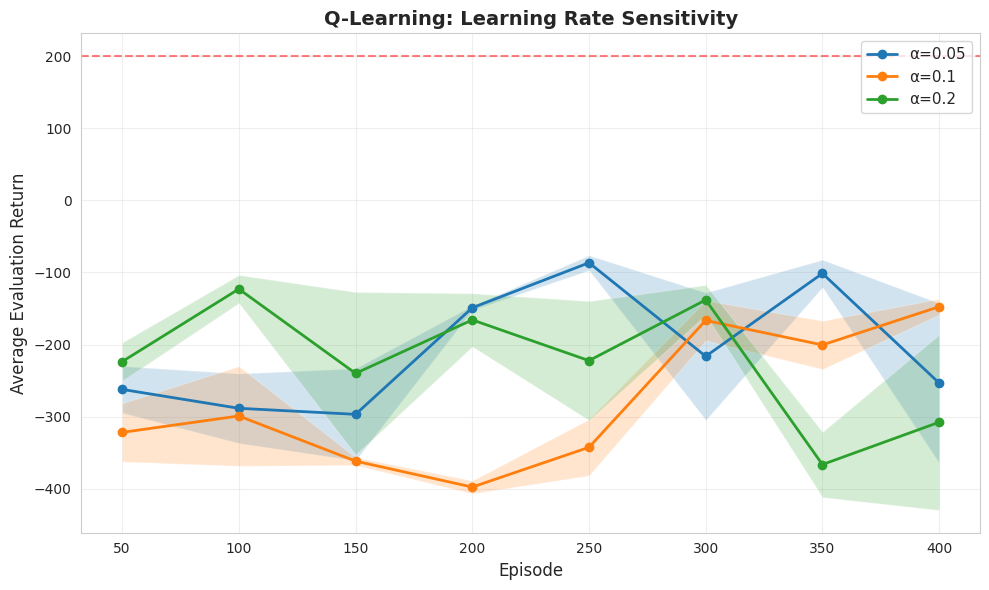


Hyperparameter sensitivity analysis complete!


In [19]:
hyperparameter_sensitivity()